In [3]:
from wandb.integration.keras import WandbMetricsLogger
from mlp_explainer import explainer, metrics
from scikeras.wrappers import KerasClassifier
from pgmpy.utils import get_example_model
from tensorflow import keras
import mlp_explainer
import numpy as np
import sklearn
import wandb
import copy

In [4]:
wandb.login()

True

In [122]:
from ucimlrepo import fetch_ucirepo 
  
car_evaluation = fetch_ucirepo(id = 19) 

X = car_evaluation.data.features.to_numpy()
y = car_evaluation.data.targets.to_numpy()

In [251]:
dataset.columns

Index(['HRBP', 'STROKEVOLUME', 'LVEDVOLUME', 'HRSAT', 'VENTALV', 'ARTCO2',
       'TPR', 'HYPOVOLEMIA', 'CVP', 'INTUBATION', 'PRESS', 'CO', 'FIO2',
       'MINVOL', 'CATECHOL', 'VENTMACH', 'HREKG', 'ERRLOWOUTPUT', 'PAP',
       'VENTLUNG', 'SAO2', 'VENTTUBE', 'LVFAILURE', 'HR', 'PVSAT',
       'PULMEMBOLUS', 'SHUNT', 'KINKEDTUBE', 'ERRCAUTER'],
      dtype='object')

  0%|          | 0/37 [00:00<?, ?it/s]

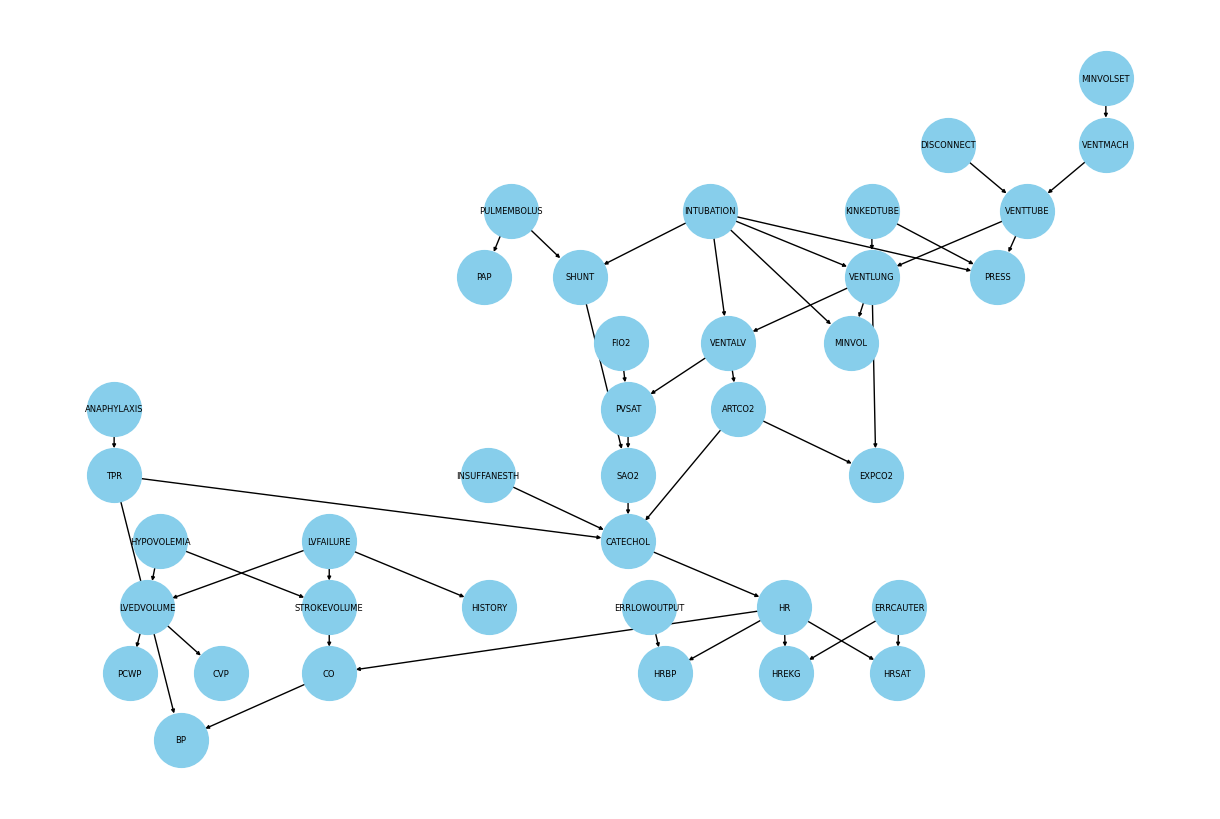

In [270]:
ground_bn = get_example_model("alarm")
dataset = ground_bn.simulate(n_samples = 1000).drop(['MINVOLSET', 'ANAPHYLAXIS', 'PCWP', 'BP', 'HISTORY', 'DISCONNECT', 'EXPCO2', 'INSUFFANESTH', 'KINKEDTUBE', 'PULMEMBOLUS', 'SAO2', 'INTUBATION', 'PRESS', 'TPR', 'LVFAILURE', 'FIO2', 'ARTCO2'], axis = 1)

X = dataset.drop('HR', axis = 1).to_numpy()
y = dataset['HR'].to_numpy()

metrics.draw_network(ground_bn)

In [271]:
def build_model(input_shape, classes, n_layers = 5, n_nodes_l = 2, n_nodes_u = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (input_shape,)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes_l, n_nodes_u)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(classes, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [272]:
n_layers = 5
n_nodes_l = 5
n_nodes_u = 50
optimizer = 'adam'
learning_rate = 0.01
epochs = 25
batch_size = 64

In [273]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size = 0.1, random_state = 42, shuffle = True
)

In [274]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X_train)

target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y_train.squeeze())

LabelEncoder()

In [275]:
X_train_proc = feature_encoder.transform(X_train)
y_train_proc = target_encoder.transform(y_train)

In [276]:
n_classes = len(np.unique(y))
input_shape = len(X[0])

In [277]:
#wandb.init(entity = "computer-vision-wits", project = "MLP-E", name = "")
    
model = build_model(
    input_shape,
    n_classes,
    n_layers = n_layers, 
    n_nodes_l = n_nodes_l,
    n_nodes_u = n_nodes_u, 
    optimizer = optimizer, 
    learning_rate = learning_rate
)

'''
config = wandb.config
config.n_layers = n_layers
config.n_nodes_l = n_nodes_l
config.n_nodes_u = n_nodes_u
config.optimizer = optimizer
config.epochs = epochs
config.batch_size = batch_size
config.learning_rate = learning_rate
'''

model.fit(X_train_proc, y_train_proc, epochs = epochs, batch_size = batch_size, validation_split = 0.2)
model.summary()

#wandb.finish()

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7569 - loss: 0.6193 - val_accuracy: 0.7944 - val_loss: 0.4593
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8083 - loss: 0.3577 - val_accuracy: 0.9389 - val_loss: 0.2377
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9389 - loss: 0.2208 - val_accuracy: 0.9389 - val_loss: 0.1734
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9403 - loss: 0.1877 - val_accuracy: 0.9444 - val_loss: 0.1534
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9556 - loss: 0.1492 - val_accuracy: 0.9556 - val_loss: 0.1325
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9625 - loss: 0.1254 - val_accuracy: 0.9556 - val_loss: 0.1281
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9625 - loss: 0.1476 - val_accuracy: 0.9611 - val_loss: 0.1378
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9667 - loss: 0.1157 - val_accuracy: 0.9500 - val_loss

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 36)             │           720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 45)             │         1,665 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 39)             │         1,794 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 40)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 19)             │           779 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,856 (77.57 KB)

 Trainable params: 6,618 (25.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,238 (51.71 KB)

In [278]:
X_test_proc = feature_encoder.transform(X_test)
y_test_proc = target_encoder.transform(y_test)

y_pred = model(X_test_proc)
y_pred = np.argmax(y_pred, axis = 1)
sklearn.metrics.accuracy_score(y_pred, y_test_proc)

0.98

In [279]:
import numpy as np
import pandas as pd
from pgmpy.estimators import PC
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

class Explainer:
    def __init__(self, model, X, preprocessor, n_samples = 100, rep_prob = 0.5):

        '''
        Args:
            model: model
            X: dataframe of X data (training, testing or all)
            preprocessor: function used to preprocess data prior to model forward pass
            n_samples: number of samples to generate for a single prediction explanation
            rep_prob: probability at which each feature value of x datapoint should be replaced with a value from a sample
        '''

        self.model = model
        self.X = X.to_numpy()
        self.preprocessor = preprocessor
        self.x_cols = X.columns
        self.y_col = 'target'
        self.n_samples = n_samples
        self.rep_prob = rep_prob
        
        self.data = None
        self.patterns = []
        self.relevance_dict = {col: 0 for col in self.x_cols}

    def __init_structures(self):
        self.data = None
        self.patterns = []
        
    def __data_generation(self, x: np.ndarray):

        y = self.model.predict(self.preprocessor(x.reshape(1, -1)), verbose=0).squeeze(0)
        y_argmax = y.argmax()
        
        random_indices = np.random.randint(len(self.X), size=self.n_samples)
        samples_X_base = self.X[random_indices]
        
        replace_mask = np.random.rand(self.n_samples, samples_X_base.shape[1]) < self.rep_prob
        
        samples_X_generated = np.where(replace_mask, x, samples_X_base)
        
        preprocessed_batch = self.preprocessor(samples_X_generated)
        
        samples_Y_raw = self.model.predict(preprocessed_batch, verbose=0)
        
        samples_Y_argmax = samples_Y_raw.argmax(axis=1)
        
        samples_Y_bool = samples_Y_argmax != y_argmax
        
        samples_X_bool = samples_X_generated != x
        
        samples_X_int = samples_X_bool.astype(int)
        samples_Y_int = samples_Y_bool.astype(int)
        
        self.data = pd.DataFrame(samples_X_int, columns=self.x_cols)
        self.data[self.y_col] = samples_Y_int


    def fp_growth(self, data, class_):

        data = data.to_numpy()
        
        encoder = TransactionEncoder()
        encoded = encoder.fit(data).transform(data)
        
        data = pd.DataFrame(encoded, columns = encoder.columns_)

        class_patterns = fpgrowth(data, min_support = 0.3, use_colnames = True)
        
        self.patterns.append(class_patterns)

    def _harmonic_merge(self):

        self.patterns[0] = self.patterns[0].rename(columns = {'support': 'stable_support'})
        self.patterns[1] = self.patterns[1].rename(columns = {'support': 'unstable_support'})
        
        patterns_merged = pd.merge(
            self.patterns[0],
            self.patterns[1],
            on = 'itemsets',
            how = 'outer'
        )
        
        patterns_merged = patterns_merged.fillna(0)
        
        support_0 = patterns_merged['support_stable']
        support_1 = patterns_merged['support_unstable']

        denominator = support_0 + support_1
        patterns_merged['Harmonic Mean'] = (2 * support_0 * support_1 / denominator).mask(denominator == 0, 0)
        
        harmonic_rank = patterns_merged[['itemsets', 'support_stable', 'support_unstable', 'Harmonic Mean']].sort_values(
            by = 'Harmonic Mean', 
            ascending = False
        )
        
        return harmonic_rank[harmonic_rank['Harmonic Mean'] > 0.0]

    def __relevance_rank(self):

        rank = self.__harmonic_merge()

        for row, idx in rank.iterrows():
    
            features = tuple(idx['itemsets'])
            h_mean = idx['Harmonic Mean']
            n_features = len(features)
            
            for feature in features:
                self.relevance_dict[feature] += h_mean / n_features

    def forward(self, x) -> None:

        self.__init_structures()
        
        self.__data_generation(x)

        for class_ in [0, 1]:
            
            class_data = self.data.loc[self.data[self.y_col] == class_]
            class_data = class_data.drop(self.y_col, axis = 1)
            
            for i, col in enumerate(class_data.columns):
                class_data[col] = np.where(class_data[col] == 0, i + 1, -(i + 1))
                
            self.fp_growth(class_data, class_)
        
        #self.__relevance_rank()

In [280]:
x_cols = dataset.drop('HR', axis = 1).columns

def preprocessor(x):
    return feature_encoder.transform(x)

In [281]:
explainer = Explainer(
    model = model,
    X = dataset.drop('HR', axis = 1),
    preprocessor = preprocessor,
    n_samples = 1000,
    rep_prob = 0.1
)

In [ ]:
for _ in range(1):
    x = X_test[np.random.randint(len(X_test))]
    explainer.forward(x)

In [ ]:
def merge(stable, unstable):

    stable = stable.rename(columns={'support': 'stable_support'})
    unstable = unstable.rename(columns={'support': 'unstable_support'})

    stable['itemsets'] = stable['itemsets'].apply(tuple)
    unstable['itemsets'] = unstable['itemsets'].apply(tuple)

    unstable = unstable.copy()
    unstable['flipped_itemsets'] = unstable['itemsets'].apply(
        lambda fs: tuple(sorted([-x for x in fs]))
    )

    merged = pd.merge(
        stable,
        unstable,
        left_on='itemsets',
        right_on='flipped_itemsets',
        how='inner',
        suffixes=('_stable', '_unstable')
    )

    merged = merged.fillna({'stable_support': 0, 'unstable_support': 0})
    merged = merged.drop(columns=['flipped_itemsets'])

    support_0 = merged['stable_support']
    support_1 = merged['unstable_support']
    denominator = support_0 + support_1
    merged['Harmonic Mean'] = (
        (2 * support_0 * support_1 / denominator)
        .mask(denominator == 0, 0)
    )

    merged = merged.rename(columns={
        'itemsets': 'itemsets_stable',
        'itemsets_unstable': 'itemsets_unstable'
    })

    merged = merged[[
        'itemsets_stable',
        'itemsets_unstable',
        'stable_support',
        'unstable_support',
        'Harmonic Mean'
    ]].sort_values(by='Harmonic Mean', ascending=False)

    return merged[merged['Harmonic Mean'] > 0.7]

merge(a, b)

In [ ]:
data = explainer.data.astype(str)
est = PC(data = data)

model_chi = est.estimate(ci_test = "chi_square", return_type = 'dag')
metrics.draw_network(model_chi)

In [228]:
s = metrics.markov_blanket(ground_bn, 'HR')
t = metrics.markov_blanket(model_chi, 'target')